# GAN을 사용한 그림 채색
* `cGAN`, `Pix2Pix` 구조와 학습
* `tensorflow GradientTape API`

## Unconditional Generative Model, GAN
## VS
## Conditional Generative Model, cGAN
### 데이터 준비하기
* MNIST 데이터셋

In [1]:
# !pip list | grep tensorflow-dataset

In [2]:
# !pip install tensorflow-dataset

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


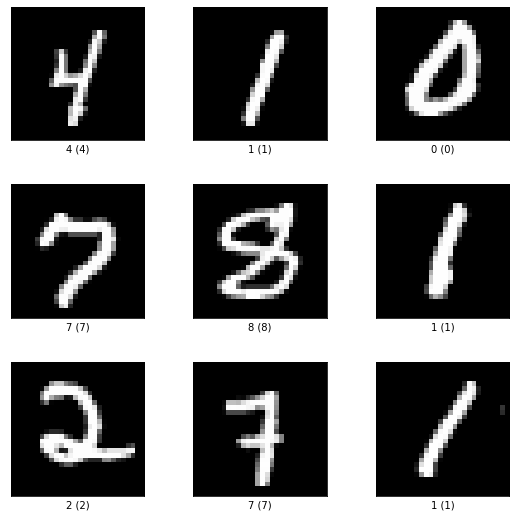

In [3]:
import tensorflow_datasets as tfds

mnist, info = tfds.load(
    'mnist', split='train', with_info=True
)

fig = tfds.show_examples(mnist, info)

* 픽셀값을 -1~1 사이의 범위로 변경
* 레이블 정보를 원-핫 인코딩
* 레이블 정보 사용 유무에 따라 gan VS cgan 으로 구분함

In [4]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data['image']
    image = tf.cast(image, tf.float32)
    image  =(image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data['image']
    image = tf.cast(image, tf.float32)
    image = (image / 127.5)  - 1
    
    label = tf.one_hot(data['label'], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


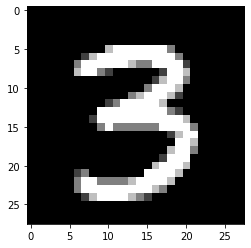

In [5]:
import matplotlib.pyplot as plt

for i, j in cgan_datasets : break
    
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

### GAN Generator 구성하기

`__init__()`메서드 안에서 사용할 모든 레이어를 정의
`call()`메서드에서 노이즈를 입력받아 정의된 레이어들을 순서대로 통과
Generator 마지막에 숫자가 쓰인 이미지로 출력하기 위해 layers.Reshape() 

In [6]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')
        
        self.reshape = layers.Reshape((28, 28, 1))
        
    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

### cGAN Generator 구성하기

In [7]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28,28,1))
        
    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
        

### GAN Discriminator 구성하기

In [8]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


### cGAN Discriminator 구성하기
### `Maxout` 레이어
`units` 차원 수를 가진 fully-connected layer를 `pieces` 개 만큼 만들고,\
그 중 최대값을 출력합니다.

In [9]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


In [10]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


## 학습 및 테스트하기

In [11]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


### GAN으로 MNIST 학습하기

In [12]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [13]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.2903494834899902, D:0.15180164575576782
[1/10 EPOCHS, 200 ITER] G:2.8865342140197754, D:0.07555174082517624
[1/10 EPOCHS, 300 ITER] G:3.0899128913879395, D:0.12187986075878143
[1/10 EPOCHS, 400 ITER] G:2.852151870727539, D:0.11112117767333984
[2/10 EPOCHS, 100 ITER] G:3.5202345848083496, D:0.08346754312515259
[2/10 EPOCHS, 200 ITER] G:3.4541196823120117, D:0.09826180338859558
[2/10 EPOCHS, 300 ITER] G:3.5664801597595215, D:0.08380789309740067
[2/10 EPOCHS, 400 ITER] G:3.805860996246338, D:0.16762381792068481
[3/10 EPOCHS, 100 ITER] G:4.368371486663818, D:0.07421229779720306
[3/10 EPOCHS, 200 ITER] G:3.642735481262207, D:0.06885243952274323
[3/10 EPOCHS, 300 ITER] G:4.447728157043457, D:0.05449497699737549
[3/10 EPOCHS, 400 ITER] G:4.507911205291748, D:0.17233037948608398
[4/10 EPOCHS, 100 ITER] G:4.876211166381836, D:0.03746110200881958
[4/10 EPOCHS, 200 ITER] G:3.7010843753814697, D:0.06600719690322876
[4/10 EPOCHS, 300 ITER] G:4.48009729385376, D:0.0306866

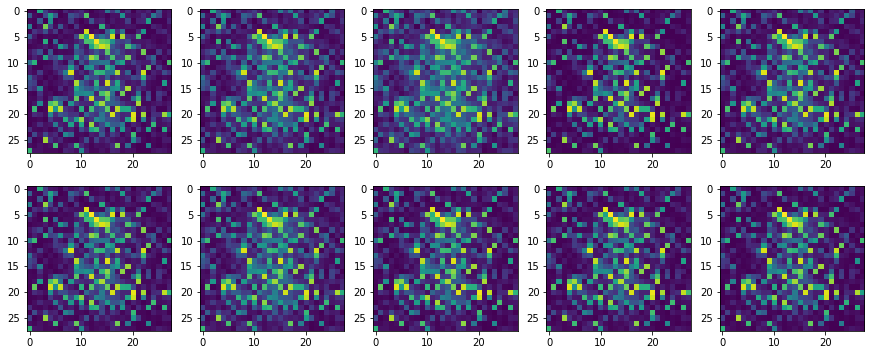

In [14]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

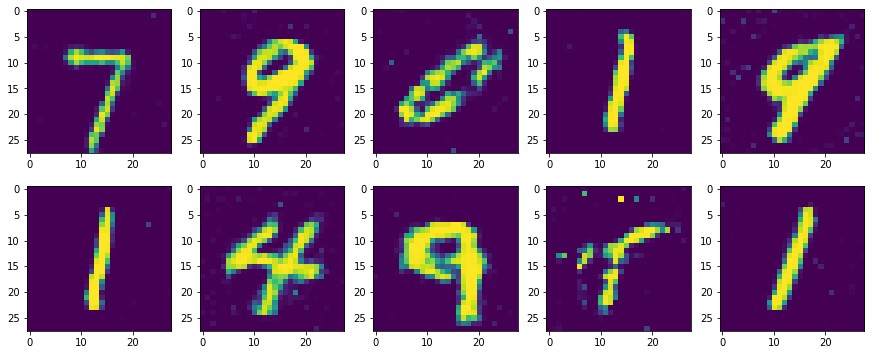

In [15]:
import os 
weight_path = os.getenv("HOME") + '/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100])

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### cGAN으로 MNIST 학습하기

In [16]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
        
        if (i+1) % 100 == 0:
            print(f'[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}')

[1/1 EPOCHS, 99 ITER] G:5.451849937438965, D:0.006325758062303066
[1/1 EPOCHS, 199 ITER] G:4.560119152069092, D:0.058879587799310684
[1/1 EPOCHS, 299 ITER] G:5.599058151245117, D:0.0286235474050045
[1/1 EPOCHS, 399 ITER] G:4.467295169830322, D:0.024774201214313507


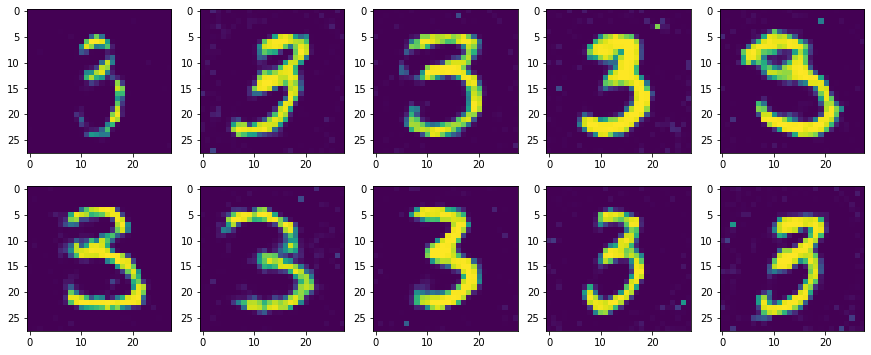

In [17]:
number = 3   # 생성할 숫자를 입력하세요!

weight_path  =os.getenv("HOME") + '/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

---
## Pix2Pix
* 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델

Ref.) **Image-to-Image Translation with Conditional Adversarial Networks**

### Generator
* `Encoder-decoder`
* `bottleneck`
* `U-net`

### Loss Function
`L1` + `cGAN`

### Discriminator

### 데이터 준비하기

In [18]:
import os

data_path = os.getenv("HOME") + '/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))


number of train examples : 830


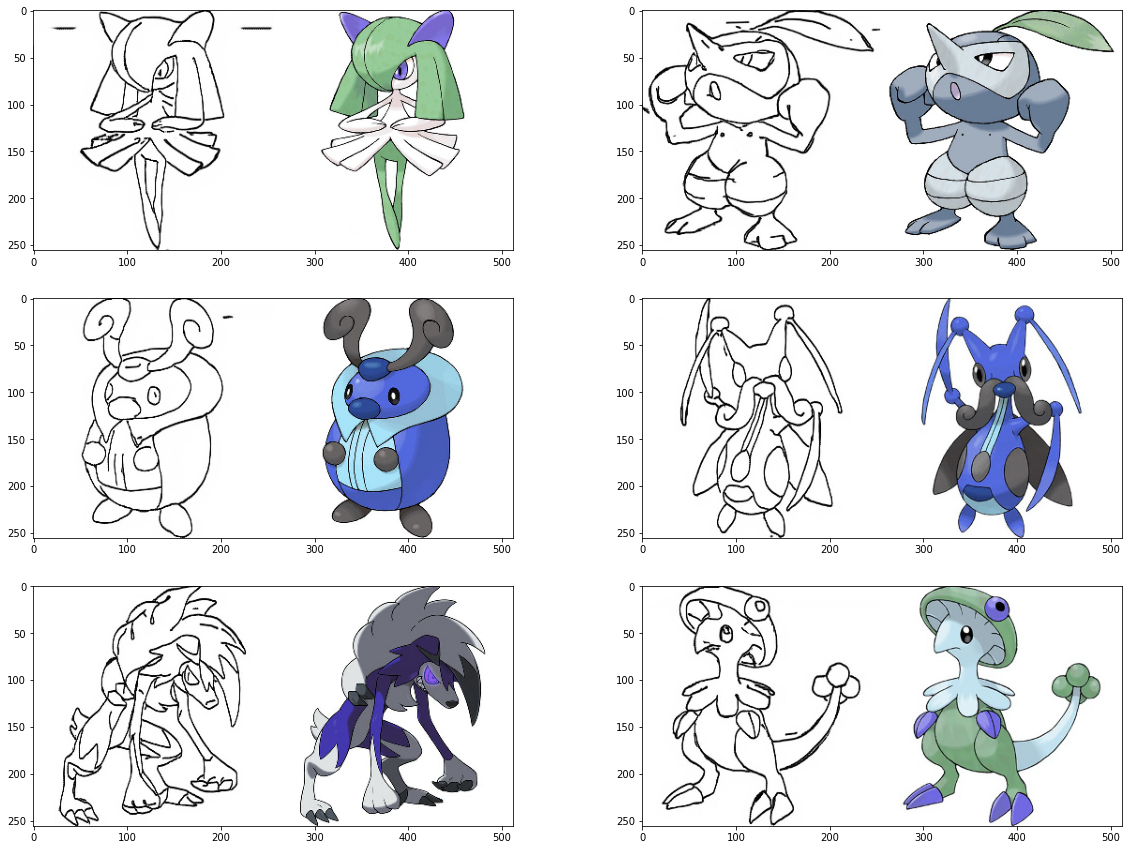

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 샘플 데이터 확인
plt.figure(figsize=(20,15))
for i in range(1,7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [20]:
f = data_path + os.listdir(data_path)[0]

img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* 데이터셋에서 이미지 쌍을 불러와 `normalize`, `denormalize`를 거쳐 그림 표시

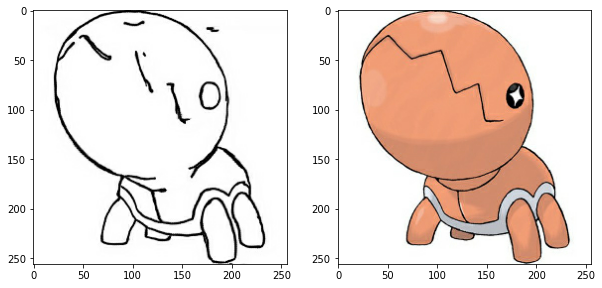

In [23]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :]
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### Data Augmentation
데이터의 샘플 수가 800 개로 적기떄문에 데이터의 다양성 확보를 위해 augmentation 수행

---
## [회고]
### 알고 있던 것
   1. `Tensorflow GradientTape API`
   2. encoder-decoder
   
### 적용해 볼 점
   1. Gradient tape 기능 예제로 여러번 연습하기! -> 지표를 보면서 파라미터 조정 과정?    2. Upsampling 기법에 대해서 나중에 확인하기 쉽도록 모아보는 자료 만들기
   
### 새롭게 알게된 것
   1. `cGAN` conditional generative adversarial network
        1. 목적 함수의 항마다 어떤 의미를 내포하는지 이해하는 작업이 굉장히 중요함!!
        2. GAN의 목적함수식에서 확률조건 항들이 변경되었다
   2. `Pix2Pix`
        1. cGAN 클래스 레이블 등의 조건 입력 -> 이미지 자체를 입력하여 원하는 형태의 이미지 출력으로 변환(image-to-image translation)
        2. Encoder + decoder 가 연결된 U-net 형태의 구조(skip connection) 
        3. `Conv. + BatchNorm + (Leaky)ReLU 유닛`이 자료에서 자주 보임
   3. 테스트 데이터 사용을 위해 디렉토리 경로를 맞춰주고, 추론결과를 나열해서 시각화하는 작업은 자주 사용할 수 있을 듯
   
### 이해가 어려운 점
   1. Pix2Pix skip connection 에서 encoder 의 정보를 '일부분'?만 가져와서 활용하는 방법?에 대해서 해당하는 코드로 설명할 수 있도록 찾아보기
   2. Batch Normalization 의 효과 및 학습 파라미터 조정과 관련된 내용 조사하기
   
### 전체 평가
   1. 생성모델에 대해서 많이 접해보지 않아 개념들을 하나하나 자세히 살펴보는데 꽤나 노력이 필요했다. 아무것도 없는 노이즈 데이터에서 학습한대로 모델이 새로운 데이터를 조금씩 만들어나가는 과정이 굉장히 흥미로웠음. 시각적이지 않은 데이터에도 유사한 방식으로 적용할 수 있을지, 연속적인 동작의 패턴 같은 정보도 담아낼 수 있을지 여러가지 궁금증이 떠오르면서 공부한 시간이었다.
   2. 시각화 툴을 필요할 때 바로 다룰 수 있도록, 자체적으로 코드(subplot, bar 등) 를 정리해 둬야할 것 같다. 더불어 Git을 좀더 활용해서 저장소 기능을 빈번하게 활용하면 좋을 듯함.